## ОБУЧИМ НЕСКОЛЬКО НЕЙРОСЕТЕЙ НА РАЗНЫХ ДАТАСЕТАХ И РАЗВЕРНЕМ ИХ С ПОМОЩЬЮ TENSORFLOW SERVING, ПРОСТЕСТИРУЕМ ВЗАИМОДЕЙСТВИЕ С НИМИ ПО API

Данильченко Вадим

In [185]:
# загрузим нужные библиотеки
import random
import numpy as np
import os
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Input 
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split

### обучим модель классифицировать датасет fashion mnist

Label	Description
* 0	T-shirt/top
* 1	Trouser
* 2	Pullover
* 3	Dress
* 4	Coat
* 5	Sandal
* 6	Shirt
* 7	Sneaker
* 8	Bag
* 9	Ankle boot

In [2]:
# скачаем датасет mnist
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
# выполним преобразование размерностей
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train / 255.0
input_shape = (28, 28, 1)

y_train = utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test / 255.0

print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [4]:
# создадим генератор изображений
batch_size = 256
num_classes = 10
epochs = 10

# размер входящего изображения
img_rows, img_cols = 28, 28


image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True, 
                                                                featurewise_std_normalization=True, 
                                                                validation_split=0.2)
image_datagen.fit(x_train)

# train
train_generator = image_datagen.flow(x_train, y_train, 
                                       shuffle=True,
                                       batch_size=batch_size,
                                       subset="training")
# test
valid_generator = image_datagen.flow(x_train, y_train, 
                                       shuffle=False,
                                       batch_size=batch_size,
                                       subset="validation")

In [5]:
# опишем архитектруру нейросети и проведем обучение

model = Sequential()
model.add(BatchNormalization(input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])


model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    # steps_per_epoch=len(x_train) // batch_size, 
                    epochs=epochs, 
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
188/188 [==============================] - 83s 438ms/step - loss: 0.6247 - accuracy: 0.7787 - val_loss: 0.3517 - val_accuracy: 0.8747
Epoch 2/10
188/188 [==============================] - 82s 435ms/step - loss: 0.3837 - accuracy: 0.8625 - val_loss: 0.2920 - val_accuracy: 0.8986
Epoch 3/10
188/188 [==============================] - 82s 434ms/step - loss: 0.3286 - accuracy: 0.8834 - val_loss: 0.2657 - val_accuracy: 0.9038
Epoch 4/10
188/188 [==============================] - 82s 435ms/step - loss: 0.2970 - accuracy: 0.8913 - val_loss: 0.2485 - val_accuracy: 0.9083
Epoch 5/10
188/188 [==============================] - 82s 435ms/step - loss: 0.2703 - accuracy: 0.9026 - val_loss: 0.2373 - val_accuracy: 0.9116
Epoch 6/10
188/188 [==============================] - 81s 433ms/step - loss: 0.2522 - accuracy: 0.9089 - val_loss: 0.2267 - val_accuracy: 0.9178
Epoch 7/10
188/188 [==============================] - 82s 434ms/step - loss: 0.2347 - accuracy: 0.9141 - val_loss: 0.2214 - val_ac

In [172]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

In [6]:
# Установка дополнительного компонента
!pip install -Uq grpcio==1.26.0

In [64]:
# задание директории для экспорта модели в SavedModel
import tempfile

MODEL_DIR = tempfile.gettempdir()
os.environ["MODEL_DIR"] = MODEL_DIR

version = 2
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

export_path = /tmp/2



In [8]:
from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model.signature_def_utils_impl import build_signature_def, predict_signature_def
import tensorflow as tf
from keras.models import model_from_config


In [138]:
# Кастомная сигнатура с помощью класса Module
class MyModule(tf.Module):
  def __init__(self, model, other_variable):
    self.model = model
    self.other_variable = other_variable

  @tf.function(input_signature=[tf.TensorSpec(shape=(1, None, None,None), dtype=tf.float32)])
  def score(self, image):
    print("shape:", image.shape)
    result = self.model(image)
    return { "scores": result }

  @tf.function(input_signature=[tf.TensorSpec([])])
  def metadata(self,x):
    return { "other_variable": self.other_variable }

module = MyModule(model, 2)
tf.saved_model.save(module, 
                    export_dir=export_path, 
                    signatures={ "score": module.score, 
                                "metadata": module.metadata })

shape: (1, None, None, None)
INFO:tensorflow:Assets written to: /tmp/2/assets


In [18]:
## Установим TF Serving
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0    99k      0 --:--:-- --:--:-- --:--:--  102k
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos

In [19]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 347 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.6.0 [347 MB]
Fetched 347 MB in 5s (67.2 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.6.0_all.deb ...
Unpacking tensorflow-model-server (2.6.0) ...
Setting up tensorflow-model-server (2.6.0) ...


In [31]:
"""
добавим конфигурацию в model.config для корректного запуска сервера с моделью
model_config_list {
  config {
    name: 'fashion_model'
    base_path: '/tmp/'
    model_platform: 'tensorflow'
    model_version_policy {
      specific {
        versions: 1
      }
    }
    version_labels {
      key: 'stable'
      value: 1
    }
    version_labels {
      key: 'canary'
      value: 1
    }
  }
}
"""

!echo "model_config_list { " \
  "config {" \
    "name: 'fashion_model'" \
    "base_path: '/tmp/'" \
    "model_platform: 'tensorflow'" \
    "model_version_policy {" \
      "specific {" \
        "versions: 1" \
      "}" \
    "}" \
    "version_labels {" \
      "key: 'stable'" \
      "value: 1" \
    "}" \
    "version_labels {" \
      "key: 'canary'" \
      "value: 1" \
    "}" \
  "}" \
"}" \
 >> models.config

In [96]:
!ps -ef | grep tensorflow_model_server

root        3356    2470  0 11:23 ?        00:00:00 /bin/bash -c ps -ef | grep tensorflow_model_server
root        3358    3356  0 11:23 ?        00:00:00 grep tensorflow_model_server


In [95]:
!kill -9 2388 2430 2673 2721 2770 2965 3075

In [220]:
# Задаем параметры запуска в tf.serving , и запускаем serving с конфигом
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --allow_version_labels_for_unavailable_models \
  --model_config_file=models.config \
  --model_config_file_poll_wait_seconds=60  >server.log 2>&1

Starting job # 10 in a separate thread.


In [99]:
!tail server.log

2021-10-14 11:23:39.278310: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-10-14 11:23:39.278427: I tensorflow_serving/model_servers/server.cc:133] Using InsecureServerCredentials
2021-10-14 11:23:39.278445: I tensorflow_serving/model_servers/server.cc:383] Profiler service is enabled
2021-10-14 11:23:39.278837: I tensorflow_serving/model_servers/server_core.cc:465] Adding/updating models.
2021-10-14 11:23:39.278887: I tensorflow_serving/model_servers/server_core.cc:591]  (Re-)adding model: fashion_model
2021-10-14 11:23:39.278920: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-10-14 11:23:39.279096: I tensorflow_serving/model_servers/server.cc:409] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename not supported
2021-10-14 11:23:39.279653: I tensorflow_serving/model_servers/server.cc:430] Exporting HTTP/REST API at:localhost:8505 ...
[evhttp_server.cc : 2

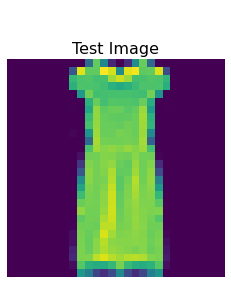

In [264]:
# Подготовка данных для запроса TF Serving

import random
import json
n_img = random.randint(0,len(x_test)-1)
# просмотр сигнатуры metadata
# data = json.dumps({"signature_name": 'metadata', "inputs": {"x":x_test[0:3].tolist()}})
data = json.dumps({"signature_name": 'score', "inputs": x_test[n_img].reshape(1, 28, 28, 1).tolist()})

## Тестовое изображение
import matplotlib.pyplot as plt
def show(idx, title):
  plt.figure()
  plt.imshow(x_test[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

show(n_img, 'Test Image')

In [149]:
# получаем предсказание

label_descr = {
    0:	'T-shirt/top',
    1:	'Trouser',
    2:	'Pullover',
    3:	'Dress',
    4:	'Coat',
    5:	'Sandal',
    6:	'Shirt',
    7:	'Sneaker',
    8:	'Bag',
    9:	'Ankle boot'}

import requests
headers = {"content-type": "application/json"}
# вызываем конкретную версию
# json_response = requests.post('http://localhost:8505/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
# по умолчанию будет работать самая старшая версия
# json_response = requests.post('http://localhost:8505/v1/models/fashion_model:predict', data=data, headers=headers)
# будет вызываться версия согласно version_labels[key]
json_response = requests.post('http://localhost:8505/v1/models/fashion_model/labels/canary:predict', data=data, headers=headers)
predictions = json_response.json()

predictions['outputs']

pred_class = np.argmax(predictions['outputs'], axis=1)[0]
print('predicted class: ', pred_class,
      '\npredicted label:', label_descr[pred_class])

predicted class:  0 
predicted label: T-shirt/top


### обучим модель классифицировать датасет cifar10

Label	Description
* 0 airplane
* 1	automobile
* 2	bird
* 3	cat
* 4	deer
* 5	dog
* 6	frog
* 7	horse
* 8	ship
* 9	truck

In [199]:
# загрузим датасет 
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = tf.keras.datasets.cifar10.load_data()
y_train_cat = to_categorical(y_train_cifar, num_classes=10)
y_test_cat = to_categorical(y_test_cifar, num_classes=10)


# нормализуем данные
x_train_cifar = x_train_cifar.astype('float')
x_train_cifar = x_train_cifar/255.
x_test_cifar = x_test_cifar.astype('float')
x_test_cifar = x_test_cifar/255.

In [200]:
# создадим генератор изображений
batch_size = 256
num_classes = 10
epochs = 10

# размер входящего изображения
img_rows, img_cols = 32, 32

image_datagen_cifar = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                                                      featurewise_std_normalization=True,
                                                                      validation_split=0.2)
image_datagen_cifar.fit(x_train_cifar)

# train
train_generator_cifar = image_datagen_cifar.flow(x_train_cifar,
                                            y_train_cat,
                                            shuffle=True,
                                            batch_size=batch_size,
                                            subset='training')
# test
valid_generator_cifar = image_datagen_cifar.flow(x_train_cifar,
                                            y_train_cat,
                                            shuffle=False,
                                            batch_size=batch_size,
                                            subset='validation')

In [208]:
# опишем архитектруру нейросети

model_cifar = Sequential()
model_cifar.add(BatchNormalization(input_shape=(img_rows,img_cols,3)))
model_cifar.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model_cifar.add(Conv2D(32, (3, 3), activation='relu'))
model_cifar.add(MaxPooling2D(pool_size=(2, 2)))
model_cifar.add(Dropout(0.25))
model_cifar.add(Flatten())
model_cifar.add(Dense(128, activation='relu'))
model_cifar.add(Dropout(0.5))
model_cifar.add(Dense(num_classes, activation='softmax'))

model_cifar.compile(loss=tf.keras.losses.categorical_crossentropy, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [210]:
model_cifar.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_56 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)             

In [209]:
# проведем обучение
model_cifar.fit_generator(generator=train_generator_cifar,
                    validation_data=valid_generator_cifar,
                    # steps_per_epoch=len(x_train) // batch_size, 
                    epochs=epochs, 
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
157/157 [==============================] - 104s 657ms/step - loss: 1.7073 - accuracy: 0.3904 - val_loss: 1.3288 - val_accuracy: 0.5321
Epoch 2/10
157/157 [==============================] - 102s 648ms/step - loss: 1.3236 - accuracy: 0.5318 - val_loss: 1.1410 - val_accuracy: 0.5903
Epoch 3/10
157/157 [==============================] - 102s 653ms/step - loss: 1.1669 - accuracy: 0.5858 - val_loss: 1.0152 - val_accuracy: 0.6432
Epoch 4/10
157/157 [==============================] - 104s 664ms/step - loss: 1.0701 - accuracy: 0.6238 - val_loss: 0.9925 - val_accuracy: 0.6491
Epoch 5/10
157/157 [==============================] - 104s 664ms/step - loss: 1.0095 - accuracy: 0.6453 - val_loss: 0.9488 - val_accuracy: 0.6655
Epoch 6/10
157/157 [==============================] - 105s 667ms/step - loss: 0.9611 - accuracy: 0.6620 - val_loss: 0.9215 - val_accuracy: 0.6800
Epoch 7/10
157/157 [==============================] - 104s 663ms/step - loss: 0.9072 - accuracy: 0.6776 - val_loss: 0.9162 -

In [211]:
# укажем путь для сохранения модели cifar10 и сохраним сигнатуру

version = 3
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

module = MyModule(model_cifar, version)
tf.saved_model.save(module, 
                    export_dir=export_path, 
                    signatures={ "score": module.score, 
                                "metadata": module.metadata })

export_path = /tmp/3

shape: (1, None, None, None)
INFO:tensorflow:Assets written to: /tmp/3/assets


predicted class:  2 
predicted label: bird


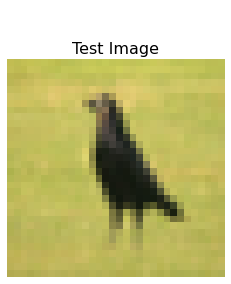

In [251]:
# Подготовка данных для запроса TF Serving

n_img = random.randint(0,len(x_test_cifar)-1)
# просмотр сигнатуры metadata
# data = json.dumps({"signature_name": 'metadata', "inputs": {"x":x_test[0:3].tolist()}})
data = json.dumps({"signature_name": 'score', "inputs": x_test_cifar[n_img].reshape(1, 32, 32, 3).tolist()})

## Тестовое изображение
import matplotlib.pyplot as plt
def show_cifar(idx, title):
  plt.figure()
  plt.imshow(x_test_cifar[idx])
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

show(n_img, 'Test Image')

# получаем предсказание

label_descr_cifar = {
  0:	'airplane',
  1:	'automobile',
  2:	'bird',
  3:	'cat',
  4:	'deer',
  5:	'dog',
  6:	'frog',
  7:	'horse',
  8:	'ship',
  9:	'truck'}

headers = {"content-type": "application/json"}
# будет вызываться версия согласно version_labels[key]
json_response = requests.post('http://localhost:8505/v1/models/cifar_model/labels/canary:predict', data=data, headers=headers)
predictions = json_response.json()

predictions['outputs']

pred_class = np.argmax(predictions['outputs'], axis=1)[0]
print('predicted class: ', pred_class,
      '\npredicted label:', label_descr_cifar[pred_class])

In [227]:
!tail server.log

2021-10-14 15:00:22.603308: I tensorflow_serving/model_servers/server.cc:133] Using InsecureServerCredentials
2021-10-14 15:00:22.603334: I tensorflow_serving/model_servers/server.cc:383] Profiler service is enabled
2021-10-14 15:00:22.603744: I tensorflow_serving/model_servers/server_core.cc:465] Adding/updating models.
2021-10-14 15:00:22.603783: I tensorflow_serving/model_servers/server_core.cc:591]  (Re-)adding model: fashion_model
2021-10-14 15:00:22.603824: I tensorflow_serving/model_servers/server_core.cc:591]  (Re-)adding model: cifar_model
2021-10-14 15:00:22.603850: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-10-14 15:00:22.614590: I tensorflow_serving/model_servers/server.cc:409] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...
2021-10-14 15:00:22.625442: I tensorflow_serving/model_servers/server.cc:430] Expor

### сделаем случайный выбор, при котором будет совершен запрос к нужной модели

In [300]:
# для одновременного взаимодействия с моделями fashion mnist и cifar10 изменим конфиг
!cat models.config

model_config_list {
  config {
    name: 'fashion_model'
    base_path: '/tmp/'
    model_platform: 'tensorflow'
    model_version_policy {
      specific {
        versions: 1
        versions: 2
      }
    }
    version_labels {
      key: 'stable'
      value: 2
    }
    version_labels {
      key: 'canary'
      value: 2
    }
  }
  config {
    name: 'cifar_model'
    base_path: '/tmp/'
    model_platform: 'tensorflow'
    model_version_policy {
      specific {
        versions: 1
        versions: 2
        versions: 3
      }
    }
    version_labels {
      key: 'stable'
      value: 3
    }
    version_labels {
      key: 'canary'
      value: 3
    }
  }
}


[[0.434081912, 0.00673348084, 0.138465419, 0.033039961, 0.0511850901, 0.00541548803, 0.26763165, 0.00687833643, 0.0525218472, 0.00404682895]]
predicted class:  0 
predicted label: T-shirt/top


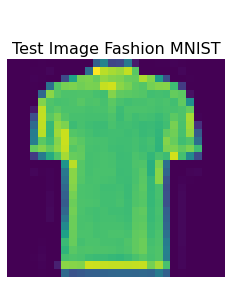

In [265]:
# сделаем случайный выбор, если 0, то пример из fashion_mnist, 1 - cifar10

def get_random_model():
  rnd_test = random.randint(0,1)

  if rnd_test:
    n_img = random.randint(0,len(x_test_cifar)-1) # случайное изображение датасета  
    data = json.dumps({"signature_name": 'score', "inputs": x_test_cifar[n_img].reshape(1, 32, 32, 3).tolist()})
    show_cifar(n_img, 'Test Image Cifar')
    json_response = requests.post('http://localhost:8505/v1/models/cifar_model/labels/canary:predict', data=data, headers=headers)
    labels = label_descr_cifar
  else:
    n_img = random.randint(0,len(x_test)-1) # случайное изображение датасета  
    data = json.dumps({"signature_name": 'score', "inputs": x_test[n_img].reshape(1, 28, 28, 1).tolist()})
    show(n_img, 'Test Image Fashion MNIST')
    json_response = requests.post('http://localhost:8505/v1/models/fashion_model/labels/canary:predict', data=data, headers=headers)
    labels = label_descr

  predictions = json_response.json()

  print(predictions['outputs'])

  pred_class = np.argmax(predictions['outputs'], axis=1)[0]
  print('predicted class: ', pred_class,
        '\npredicted label:', labels[pred_class])
  
get_random_model()

[[0.0572294, 0.0130970106, 0.00325491559, 0.885371208, 0.013352205, 0.000544430513, 0.0209443159, 0.00315202074, 0.00144100853, 0.00161358353]]
predicted class:  3 
predicted label: Dress


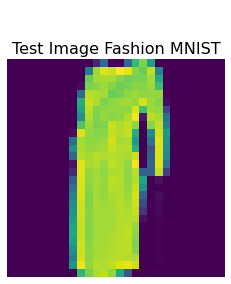

In [269]:
get_random_model()

[[0.121286452, 0.00162722927, 0.319627, 0.0869022831, 0.350264549, 0.0749025866, 0.0146673163, 0.0139084263, 0.0154793533, 0.00133477338]]
predicted class:  4 
predicted label: deer


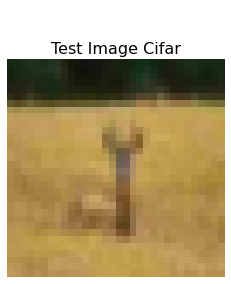

In [270]:
get_random_model()

[[0.104828797, 0.00764934532, 0.134385228, 0.206608504, 0.172078192, 0.0625179335, 0.228354305, 0.00406745216, 0.0742416307, 0.00526858959]]
predicted class:  6 
predicted label: frog


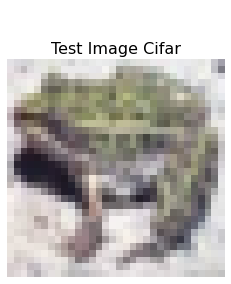

In [293]:
get_random_model()

[[0.00799616799, 0.0103140166, 0.00410580868, 0.00843319762, 0.00754385581, 0.0127370944, 0.00676756212, 0.0555251688, 0.00665879762, 0.879918337]]
predicted class:  9 
predicted label: Ankle boot


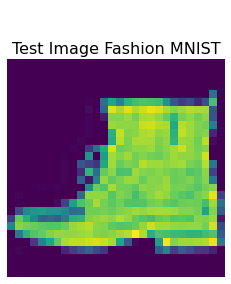

In [297]:
get_random_model()